# LSTM

## 라이브러리

In [188]:
# module 'tensorflow.compat.v2.__internal__.tracking' has no attribute 'no_automatic_dependency_tracking'
# 에러 발생시 몇번 더 실행하면 정상적으로 실행됨


import pandas as pd
import numpy as np
import re               # Regular Expression
import pickle           # 토큰화된 단어목록의 인덱스를 저장, 불러오기 위해 사용
from tqdm import tqdm   # 진행상황 Progress Bar를 위한 tqdm library

# 토크나이징/인코딩 관련 라이브러리
from eunjeon import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from keras.utils import np_utils

# 모델링 관련 라이브러리
from tensorflow.keras.models import load_model

# 그래프 관련 라이브러리
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 

데이터 불러오기

In [189]:
X_train = np.array(pd.read_csv('./data/mecab/X_train.csv'))
X_valid = np.array(pd.read_csv('./data/mecab/X_valid.csv'))
X_test = np.array(pd.read_csv('./data/mecab/X_test.csv'))

y_train_1 = pd.read_csv('./data/mecab/y_train.csv')['digit_1']
y_valid_1 =  pd.read_csv('./data/mecab/y_valid.csv')['digit_1']

y_train_2 = pd.read_csv('./data/mecab/y_train.csv')['digit_2']
y_valid_2 =  pd.read_csv('./data/mecab/y_valid.csv')['digit_2']

y_train_3 = pd.read_csv('./data/mecab/y_train.csv')['digit_3']
y_valid_3 =  pd.read_csv('./data/mecab/y_valid.csv')['digit_3']

In [190]:
# 한국표준산업분류 딕셔너리 불러오기

with open('./data/dictionary/digit_1_dict.pickle', 'rb') as handle:
    digit_1_dict = pickle.load(handle)

with open('./data/dictionary/digit_2_dict.pickle', 'rb') as handle:
    digit_2_dict = pickle.load(handle)

with open('./data/dictionary/digit_3_dict.pickle', 'rb') as handle:
    digit_3_dict = pickle.load(handle)

In [191]:
# 저장된 Tokenizer 객체를 불러오는 부분

with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## 대분류

In [192]:
# 레이블 인코딩

digit_1_list = list(digit_1_dict.keys())

le1 = preprocessing.LabelEncoder()

le1.fit(digit_1_list)
y_train_1 = le1.transform(y_train_1)
y_valid_1 = le1.transform(y_valid_1)

y_train_1 = np_utils.to_categorical(y_train_1)
y_valid_1 = np_utils.to_categorical(y_valid_1)


# le1 객체에 담긴 어휘 분석 정보가 폴더의 le1.pickle에 저장

with open('./data/mecab/le1.pickle', 'wb') as handle:
     pickle.dump(le1, handle)

Epoch 1/10
6400/6400 [==============================] - 235s 37ms/step - loss: 0.1522 - acc: 0.9580 - val_loss: 0.0962 - val_acc: 0.9732

Epoch 00001: val_acc improved from -inf to 0.97317, saving model to mecab_d1_ed100_hu128_ep10_bs128_sftmx_cc.h5
Epoch 2/10
6400/6400 [==============================] - 258s 40ms/step - loss: 0.0780 - acc: 0.9773 - val_loss: 0.0878 - val_acc: 0.9752

Epoch 00002: val_acc improved from 0.97317 to 0.97516, saving model to mecab_d1_ed100_hu128_ep10_bs128_sftmx_cc.h5
Epoch 3/10
6400/6400 [==============================] - 288s 45ms/step - loss: 0.0641 - acc: 0.9809 - val_loss: 0.0883 - val_acc: 0.9752

Epoch 00003: val_acc did not improve from 0.97516
Epoch 4/10
6400/6400 [==============================] - 286s 45ms/step - loss: 0.0551 - acc: 0.9836 - val_loss: 0.0908 - val_acc: 0.9750

Epoch 00004: val_acc did not improve from 0.97516
Epoch 00004: early stopping


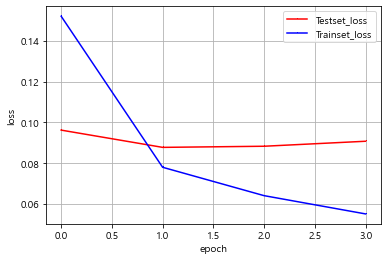

In [54]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

vocab_size = 35721
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(19, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('mecab_d1_ed100_hu128_ep10_bs128_sftmx_cc.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_1, epochs=10, callbacks=[es, mc], batch_size=100, validation_split=0.2)

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [193]:
loaded_model = load_model('./mecab_d1_ed100_hu128_ep10_bs128_sftmx_cc.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_valid, y_valid_1)[1]))

6250/6250 [==============================] - 63s 10ms/step - loss: 0.0894 - acc: 0.9745

 테스트 정확도: 0.9745


In [195]:
# 저장된 le1 객체를 불러오는 부분

with open('./data/mecab/le1.pickle', 'rb') as handle:
    le1 = pickle.load(handle)

loaded_model = load_model('./mecab_d1_ed100_hu128_ep10_bs128_sftmx_cc.h5')
y_valid_1_predicted = loaded_model.predict(X_valid)

temp_list_1 = []

for i in tqdm(range(0, len(y_valid_1_predicted))):
    temp_list_1.append([le1.inverse_transform([y_valid_1_predicted[i].argmax()])[0]])
temp_list_1 = le1.transform(temp_list_1)
temp_list_1 = np_utils.to_categorical(temp_list_1)

100%|██████████| 200000/200000 [00:16<00:00, 12238.27it/s]


In [145]:
temp_list_1.astype('int32')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [186]:
X_valid = np.concatenate((temp_list_1, X_valid), axis=1)

In [181]:
a

array([[   7,    0,    0, ...,   18,   10,    2],
       [   8,    0,    0, ...,    6,  924, 2155],
       [   2,    0,    0, ..., 3552, 4789, 1067],
       ...,
       [   8,    0,    0, ...,  256,  449,    9],
       [   7,    0,    0, ...,   18,   10,    2],
       [  11,    0,    0, ...,   80,   95,   31]], dtype=int64)

In [138]:
a = temp_list_1.concat(X_valid)

AttributeError: 'numpy.ndarray' object has no attribute 'concat'

In [127]:
X_valid[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0, 32, 21,  3, 16, 18, 10,  2],
      dtype=int64)

In [128]:
temp_list_1['text'] = list(X_valid)

In [132]:
temp_list_1 = np.array(temp_list_1)

### 대분류 예측기

In [20]:
# 저장된 Tokenizer 객체를 불러오는 부분

with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [24]:
tokenizer.word_index

{"'����'": 1,
 "'���'": 2,
 "'��'": 3,
 "'������'": 4,
 "'�����'": 5,
 "'�ϲ�'": 6,
 "'�ü�'": 7,
 "'�ǹ�'": 8,
 "'�һ���'": 9,
 "'�ϲ���'": 10,
 "'�ҹ�'": 11,
 "'��û'": 12,
 "'ȭ��'": 13,
 "'��ǰ'": 14,
 "'�ƿ�'": 15,
 "'ȭ���ڵ���'": 16,
 "'�ε���'": 17,
 "'�߰�'": 18,
 "'�°�'": 19,
 "'�����ý�'": 20,
 "'�繫��'": 21,
 "'�п�'": 22,
 "'�ڵ���'": 23,
 "'ŀ��'": 24,
 "'�л�'": 25,
 "'�ҹž���'": 26,
 "'ü��'": 27,
 "'��ȸ'": 28,
 "'ȱ��'": 29,
 "'�̿��'": 30,
 "'ȯ��'": 31,
 "'��ʈ'": 32,
 "'ö��'": 33,
 "'��ġ'": 34,
 "'�ܷ�'": 35,
 "'�\ueff5'": 36,
 "'ġ��'": 37,
 "'�̿�'": 38,
 "'����ʈ'": 39,
 "'�ǽ�'": 40,
 "'�ĸ�'": 41,
 "'��ü'": 42,
 "'�ѽ�'": 43,
 "'�䱸'": 44,
 "'��������'": 45,
 "'��ź'": 46,
 "'�ֹ�'": 47,
 "'�ǰ�'": 48,
 "'��ȭ'": 49,
 "'ġų'": 50,
 "'�\u2d76��'": 51,
 "'�ǿ�'": 52,
 "'�뷡��'": 53,
 "'���ķ�ǰ'": 54,
 "'ȸ��'": 55,
 "'�ĵ�'": 56,
 "'�\uee30��'": 57,
 "'ö'": 58,
 "'�ݼ�'": 59,
 "'ȭ��ǰ'": 60,
 "'�ǻ�'": 61,
 "'�߹�'": 62,
 "'��ź��'": 63,
 "'�ְ�'": 64,
 "'��ǻ��'": 65,
 "'�ӵ�'": 66,
 "'�ǳ�'": 67,
 "'�\u0530�'": 6

In [92]:
mecab = Mecab()
loaded_model = load_model('./ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords.csv')
stopwords = list(stopwords['stopwords'])


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le1.inverse_transform([label.argmax()])[0])
  print(digit_1_dict[le1.inverse_transform([label.argmax()])[0]])

In [93]:
sentiment_predict("카센터에서|자동차부분정비|타이어오일교환")

카센터에서자동차부분정비타이어오일교환
['카센터', '에서', '자동차', '부분', '정비', '타이어', '오', '일', '교환']
['카센터', '에서', '자동차', '부분', '정비', '타이어', '오', '일', '교환']
[[607, 40, 210, 264, 257, 931]]
[[  0   0   0   0   0   0   0   0   0 607  40 210 264 257 931]]
[[4.1274594e-05 5.7865927e-06 5.8053585e-04 1.6885963e-07 6.4396788e-04
  6.3920606e-06 1.3797742e-05 9.4412053e-06 1.1517714e-06 7.4284566e-05
  2.0624391e-06 2.2640058e-06 3.1059209e-04 4.9767538e-04 5.8264245e-04
  1.5870976e-03 9.9255306e-01 3.3423206e-05 3.0544442e-03]]
Q
보건업 및 사회복지 서비스업(86~87)


In [ ]:
# y_test_1_predicted = pd.DataFrame(loaded_model.predict(X_test))

## 중분류

In [183]:
a

array([[   7,    0,    0, ...,   18,   10,    2],
       [   8,    0,    0, ...,    6,  924, 2155],
       [   2,    0,    0, ..., 3552, 4789, 1067],
       ...,
       [   8,    0,    0, ...,  256,  449,    9],
       [   7,    0,    0, ...,   18,   10,    2],
       [  11,    0,    0, ...,   80,   95,   31]], dtype=int64)

In [16]:
len(pd.DataFrame(y_train_2)['digit_2'].unique())

74

In [17]:
len(digit_2_dict)

77

In [55]:
# 레이블 인코딩

digit_2_list = list(digit_2_dict.keys())

le2 = preprocessing.LabelEncoder()

le2.fit(digit_2_list)
y_train_2 = le2.transform(y_train_2)
y_valid_2 = le2.transform(y_valid_2)

y_train_2 = np_utils.to_categorical(y_train_2, num_classes=len(digit_2_list))
y_valid_2 = np_utils.to_categorical(y_valid_2, num_classes=len(digit_2_list))

In [64]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

vocab_size = 35721
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(154, activation='softmax'))
model.add(Dense(77, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('mecab_d2_ed100_hu256_ep10_bs128_sftmx_cc.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_2, epochs=10, callbacks=[es, mc], batch_size=100, validation_split=0.2)

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Epoch 1/10
3263/6400 [==============>...............] - ETA: 3:42 - loss: 3.2398 - acc: 0.1735

KeyboardInterrupt: 

In [182]:
loaded_model = load_model('./mecab_d2_ed100_hu128_ep10_bs128_sftmx_cc.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(a, y_valid_2)[1]))

6250/6250 [==============================] - 66s 11ms/step - loss: 0.2157 - acc: 0.9404

 테스트 정확도: 0.9404


In [39]:
X_test

array([['id_000001', nan, nan, nan,
        "['ġŲ', '������', '����', '�ֹ�', 'ġŲ', '�Ǹ�']"],
       ['id_000002', nan, nan, nan,
        "['���', '����', '�Ҹž���', 'ö��', '������']"],
       ['id_000003', nan, nan, nan,
        "['��', '�ŵ�', '���', '�ұ�', '��ü', '�\ueff5']"],
       ...,
       ['id_099998', nan, nan, nan,
        "['�Ϲ�', '����', '�Һ���', '�\u05f8�', '�Ǹ�']"],
       ['id_099999', nan, nan, nan,
        "['�����', '�Ϲ�', '��', '�л�', '���', '�н�', '����', '����']"],
       ['id_100000', nan, nan, nan,
        "['�����', '�븮', '����', '����Ʈ', '����']"]], dtype=object)

In [37]:
y_valid_2[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
y_valid_2=np.asarray(y_valid_2).astype(np.int)

In [34]:
y_valid_2.astype(float)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
y_valid_2 = np.asarray(y_valid_2).astype('float32')

### 중분류 예측기

In [16]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit2_ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv')


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le2.inverse_transform([label.argmax()])[0])
  print(digit_2_dict[le2.inverse_transform([label.argmax()])[0]])

In [18]:
sentiment_predict('영어학원|일반학생대상|영어교육')

영어학원일반학생대상영어교육
['영어', '학원', '일반', '학생', '대상', '영어', '교육']
['영어', '학원', '일반', '학생', '대상', '영어', '교육']
[[106, 30, 10, 38, 1, 106, 28]]
[[  0   0   0   0   0   0   0   0 106  30  10  38   1 106  28]]
[[3.3901244e-09 2.0897637e-08 3.8126666e-09 3.0675029e-10 2.2629222e-10
  7.9605428e-08 3.2770386e-10 8.7994927e-08 7.0510360e-08 2.0747966e-10
  2.8677161e-07 4.2352216e-08 2.1015593e-08 6.9544690e-08 1.5907085e-09
  7.6828748e-08 1.1855049e-10 3.5715878e-08 2.3497962e-07 2.0660003e-08
  3.3980680e-07 8.5391652e-11 4.7124776e-10 4.9496984e-09 2.7503464e-07
  1.2095218e-09 3.9833288e-09 6.8410988e-09 2.5822013e-09 3.7302346e-08
  2.2491537e-07 3.1255757e-07 4.7099481e-12 5.2456600e-10 2.8596964e-10
  2.7771394e-08 7.6750064e-09 1.4437527e-06 1.7732052e-07 8.7860883e-09
  2.1529750e-06 2.5718451e-05 3.7065444e-09 8.7804473e-08 8.3038493e-10
  5.5193863e-09 1.8413728e-07 5.3079219e-07 3.3821743e-07 6.4629234e-07
  3.9017416e-09 2.1560042e-07 1.5189957e-07 2.1014881e-07 1.7168924e-08
  9.9406627

In [54]:
loaded_model = load_model('./best_model2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test_3)[1]))

6250/6250 [==============================] - 51s 8ms/step - loss: 13.4765 - acc: 0.0036

 테스트 정확도: 0.0036


## 소분류

In [30]:
# 레이블 인코딩

digit_3_list = list(digit_3_dict.keys())

le3 = preprocessing.LabelEncoder()

le3.fit(digit_3_list)
y_train_3 = le3.transform(y_train_3)
y_valid_3 = le3.transform(y_valid_3)

y_train_3 = np_utils.to_categorical(y_train_3, num_classes=len(digit_3_list))
y_valid_3 = np_utils.to_categorical(y_valid_3, num_classes=len(digit_3_list))

In [57]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

vocab_size = 35721
embedding_dim = 200
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(232, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('mecab_d3_ed200_hu128_ep10_bs128_sftmx_cc.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_3, epochs=10, callbacks=[es, mc], batch_size=100, validation_split=0.2)

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Epoch 1/10


ValueError: in user code:

    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:850 train_function  *
        return step_function(self, iterator)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:840 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:833 run_step  **
        outputs = model.train_step(data)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:791 train_step
        loss = self.compiled_loss(
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\Huitaek\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (100, 1) and (100, 232) are incompatible


In [46]:
loaded_model = load_model('./mecab_d3_ed200_hu128_ep10_bs128_sftmx_cc.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_valid, y_valid_3)[1]))

6250/6250 [==============================] - 27s 4ms/step - loss: 0.3227 - acc: 0.9157

 테스트 정확도: 0.9157


### 소분류 예측기

In [46]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit3_ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv')


def sentiment_predict2(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le3.inverse_transform([label.argmax()])[0])
  print(digit_3_dict[le3.inverse_transform([label.argmax()])[0]])

In [48]:
sentiment_predict2('정비회사에서|자동차의전반적인|정비 종합수리서비스')

정비회사에서자동차의전반적인정비 종합수리서비스
['정비', '회사', '에서', '자동차', '의', '전반', '적', '인', '정비', '종합', '수리', '서비스']
['정비', '회사', '에서', '자동차', '의', '전반', '적', '인', '정비', '종합', '수리', '서비스']
[[271, 291, 43, 2169, 175, 271, 228, 46, 2]]
[[   0    0    0    0    0    0  271  291   43 2169  175  271  228   46
     2]]
[[2.25543495e-08 6.05824141e-07 1.46671744e-10 1.06609705e-05
  7.70816674e-11 1.70350845e-08 1.28942315e-10 1.73955748e-08
  2.46597381e-10 1.65171571e-10 2.27767916e-10 3.23220062e-10
  1.34238731e-10 1.91093894e-11 5.29234256e-09 2.25108465e-09
  1.76460874e-10 2.92087021e-09 1.63499308e-07 2.07227679e-10
  4.81583350e-11 1.70529315e-08 4.16814459e-08 2.74717887e-11
  7.91270249e-09 1.07565179e-09 1.90920557e-10 1.01880504e-09
  1.30524966e-10 1.16911991e-09 2.71794809e-09 1.13763790e-11
  4.21847973e-10 1.15860023e-12 2.39433307e-10 3.19270010e-09
  1.26816024e-09 6.26243875e-08 7.20114857e-09 2.93753466e-10
  6.30222132e-08 5.38868399e-08 8.70925376e-09 3.78718461e-08
  1.62408498e-09 8.9349

## 최종 예측 모델 결합, 답안 제출

In [78]:
# 대분류/중분류/소분류 예측 모델 불러오기, 불러온 모델로 test data 예측

test_data = np.array(pd.read_csv('./data/mecab/test_data.csv'))

loaded_model_1 = load_model('./data/model/digit1_ed200_hu128_ep10_bs128_sftmx_cc.h5')
y_test_1_predicted = loaded_model_1.predict(test_data)

loaded_model_2 = load_model('./data/model/digit2_ed200_hu128_ep10_bs128_sftmx_cc.h5')
y_test_2_predicted = loaded_model_2.predict(test_data)

loaded_model_3 = load_model('./data/model/digit3_ed200_hu128_ep10_bs128_sftmx_cc.h5')
y_test_3_predicted = loaded_model_3.predict(test_data)

In [108]:
# 인코딩된 예측값 원래 형태로 원상 복구

temp_list_1 = []
temp_list_2 = []
temp_list_3 = []

for i in tqdm(range(0, len(y_test_1_predicted))):
    temp_list_1.append(le1.inverse_transform([y_test_1_predicted[i].argmax()])[0])
    temp_list_2.append(le2.inverse_transform([y_test_2_predicted[i].argmax()])[0])
    temp_list_3.append(le3.inverse_transform([y_test_3_predicted[i].argmax()])[0])

100%|██████████| 100000/100000 [00:11<00:00, 8534.98it/s]


In [117]:
# 답안 작성용 파일에 대분류/중분류/소분류 예측 컬럼 삽입 후 csv 파일로 저장

test_data = pd.read_csv('./data/test.csv')

test_data['digit_1'] = temp_list_1
test_data['digit_2'] = temp_list_2
test_data['digit_3'] = temp_list_3

test_data.to_csv('./data/output/답안 작성용 파일.csv', encoding='CP949', index=False)

In [124]:
# 결과값 검정 용이를 위해 산업분류 사전과 매핑한 csv 저장

translated_data = test_data.copy()
translated_data['digit_1'] = translated_data['digit_1'].replace(digit_1_dict)
translated_data['digit_2'] = translated_data['digit_2'].replace(digit_2_dict)
translated_data['digit_3'] = translated_data['digit_3'].replace(digit_3_dict)

translated_data.to_csv('./data/output/final_translated.csv', encoding='CP949', index=False)